In [14]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
folder = './2_PAT/'
files = os.listdir(folder)

In [16]:
# Make list of participants
IDs = []
for file in files:
    IDs.append(file.split('_')[1].split('-')[0])

uniqueIDs = list(set(IDs))
uniqueIDs.sort()
N_part = len(uniqueIDs)

In [17]:
def create_2df(file_name):
    
    ''' 
    Creates 2 data frames from the inputed log file 
    '''
    
    # Read log file
    with open(file_name, newline = '') as file_:                                                                                          
        file_reader = csv.reader(file_, delimiter='\t')
        text = list(file_reader)
    
    table1_index = text.index(['Subject', 'Trial', 'Event Type', 'Code', 'Time', 'TTime', 'Uncertainty', 'Duration', 'Uncertainty', 'ReqTime', 'ReqDur', 'Stim Type', 'Pair Index'])
    table2_index = text.index(['Event Type', 'Code', 'Type', 'Response', 'RT', 'RT Uncertainty', 'Time', 'Uncertainty', 'Duration', 'Uncertainty', 'ReqTime', 'ReqDur'])
    
    df1 = pd.DataFrame.from_records(text[table1_index+1:table2_index])
    df1.columns = text[table1_index]
    df1.dropna(how='all', inplace=True)

    df2 = pd.DataFrame.from_records(text[table2_index+1::])
    df2.columns = text[table2_index]
    df2.dropna(how='all', inplace=True)
    
    return df1, df2

In [18]:
def clean_df2(df2):
    
    ''' 
    Remove useless rows and columns in df2
    '''
        
    # Rows: Keep only hit/miss and fb trials
    df2new = df2.drop(df2[(df2.Code=='Fix')].index, inplace=False)
    df2new = df2new.drop(df2new[(df2new.Code=='Instruction_Run_1')].index, inplace=False)
    df2new = df2new.drop(df2new[(df2new.Code=='Wait_for_scanner')].index, inplace=False)
    df2new = df2new.drop(df2new[(df2new.Code=='EndText')].index, inplace=False)

    # Columns: Drop unimportant columns
    df2new = df2new.drop(columns=['RT', 'RT Uncertainty', 'Uncertainty', 'ReqTime', 'ReqDur'], inplace=False)
    
    return df2new

In [19]:
def reformat_cues_fb(df2):
    
    ''' 
    Reformat (have cues and fb in columns instead of rows after each other)
    '''
    
    df2_cues = df2[0::2]
    df2_cues.reset_index(inplace=True)

    df2_fb = df2[1::2]
    df2_fb.reset_index(inplace=True)
    
    # Change names to avoid duplicates
    df2_fb.set_axis(['FB index', 'FB Event Type', 'FB Code', 'FB Type', 'FB Response', 'FB Time', 'FB Duration'], axis=1, inplace=True) 

    df2_new = pd.concat([df2_cues, df2_fb], axis=1)
    
    return df2_new

In [20]:
def count_fb_by_cue(df2):
    
    ''' 
    Count the recieved fb split in cue condition
    '''
    
    # Create an empty df with all columns and rows names
    FB_values = ['FB_1','FB_-1','FB_5','FB_-5','FB_no_1','FB_no_-1','FB_no_5','FB_no_-5']
    cue_values = list(sorted(set(df2['Code'])))
    big_df = pd.DataFrame([],columns=cue_values, index=FB_values)

    for cue_value in cue_values:

        # for each cue condition create df with the counts
        small_df = df2[df2['Code']==cue_value]['FB Code'].value_counts().to_frame(cue_value)

        # fill in the df
        big_df = big_df.combine_first(small_df)

    df2_count = big_df.transpose()
    df2_count.reset_index(level=0, inplace=True)
    
    return df2_count

In [21]:
all_counts = pd.DataFrame([])

for ID in uniqueIDs:
    
    # Extract data into 2 dfs (for run1 and run2)
    df1_run1, df2_run1 = create_2df(folder + 'MARS_' + ID + '-PA_europ.log')
    df1_run2, df2_run2 = create_2df(folder + 'MARS_' + ID + '-PA_europ1.log') 

    # Focus on df2 becase has hit/miss/FB info

    # Clean (remove useless rows and cols)
    df2_run1_c = clean_df2(df2_run1)

    # Reformat (have fb in a column instead of row below)
    df2_run1_cf = reformat_cues_fb(df2_run1_c)

    # Count fb for each cue
    df2_run1_count = count_fb_by_cue(df2_run1_cf)

    # Append each participant df in a big df (=all_counts)
    tmp=df2_run1_count.fillna(0)
    tmp.insert(0,'ID',ID)
    all_counts = pd.concat([all_counts, tmp])
    
all_counts.rename(columns={"index": "Cue"}, inplace=True)
all_counts.reset_index(inplace=True)
all_counts.drop('index', axis=1, inplace=True)

In [22]:
all_counts.head(5)

,ID,Cue,FB_-1,FB_-5,FB_1,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5
0,001,Cue_HP,0.0,0.0,0.0,0.0,3.0,7.0,2.0,2.0
1,001,Cue_HR,1.0,2.0,1.0,1.0,1.0,0.0,2.0,6.0
2,001,Cue_LP,0.0,1.0,0.0,0.0,5.0,4.0,2.0,2.0
3,001,Cue_LR,1.0,1.0,4.0,3.0,1.0,1.0,1.0,2.0
4,003,Cue_HP,1.0,2.0,0.0,1.0,2.0,5.0,2.0,1.0


In [23]:
summ_stats = all_counts.drop('ID', axis=1).groupby("Cue").agg([np.mean, np.std])
summ_stats

FB_-1               FB_-5                FB_1                FB_5  \
            mean       std      mean       std      mean       std      mean   
Cue                                                                            
Cue_HP  1.029412  0.879931  2.223529  1.627257  0.541176  0.697467  0.547059   
Cue_HR  1.629412  0.603995  1.682353  0.590091  2.341176  1.021114  5.347059   
Cue_LP  1.705882  1.361547  1.688235  1.283663  0.600000  0.716666  0.511765   
Cue_LR  1.664706  0.595288  1.611765  0.672259  3.952941  1.522268  3.947059   

                  FB_no_-1            FB_no_-5             FB_no_1            \
             std      mean       std      mean       std      mean       std   
Cue                                                                            
Cue_HP  0.730257  1.970588  0.879931  4.776471  1.627257  1.458824  0.697467   
Cue_HR  2.274796  0.370588  0.603995  0.317647  0.590091  0.658824  1.021114   
Cue_LP  0.723553  3.294118  1.361547  3.311765  1.283663  1.400000  0.716666   
Cue_LR  1.558568  0.335294  0.595288  0.388235  0.672259  1.047059  1.522268   

         FB_no_5            
            mean       std  
Cue                         
Cue_HP  1.452941  0.730257  
Cue_HR  1.652941  2.274796  
Cue_LP  1.488235  0.723553  
Cue_LR  1.052941  1.558568

In [59]:
means

,FB_-1,FB_-5,FB_1,FB_5,FB_no_-1,FB_no_-5,FB_no_1,FB_no_5
Cue,,,,,,,,
Cue_HP,1.029412,2.223529,0.541176,0.547059,1.970588,4.776471,1.458824,1.452941
Cue_HR,1.629412,1.682353,2.341176,5.347059,0.370588,0.317647,0.658824,1.652941
Cue_LP,1.705882,1.688235,0.600000,0.511765,3.294118,3.311765,1.400000,1.488235
Cue_LR,1.664706,1.611765,3.952941,3.947059,0.335294,0.388235,1.047059,1.052941


In [149]:
means = all_counts.drop('ID', axis=1).groupby("Cue").agg(np.mean)
std = all_counts.drop('ID', axis=1).groupby("Cue").agg(np.std)

means_hit = means[['FB_-5','FB_-1','FB_1','FB_5']]
means_miss = means[['FB_no_-5','FB_no_-1','FB_no_1','FB_no_5']]

std_hit = std[['FB_-5','FB_-1','FB_1','FB_5']]
std_miss = std[['FB_no_-5','FB_no_-1','FB_no_1','FB_no_5']]

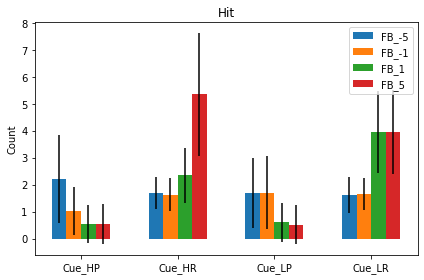

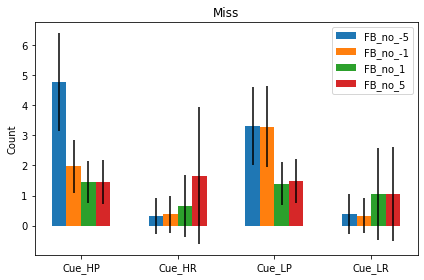

In [162]:
# HIT

x_labels = means_hit.index.to_list()
y_labels = means_hit.columns.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()

i = 0
for col in means_hit:
    rects1 = ax.bar(x = x+i*width-width/2*3, 
                    height = means_hit[col].tolist(), yerr=std_hit[col].tolist(), 
                    width = width, label=y_labels[i])
    i+=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Hit')
ax.set_xticks(x, x_labels)
ax.legend()

fig.tight_layout()

plt.show()



# MISS


x_labels = means_miss.index.to_list()
y_labels = means_miss.columns.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()

i = 0
for col in means_miss:
    rects1 = ax.bar(x = x+i*width-width/2*3, 
                    height = means_miss[col].tolist(), yerr=std_miss[col].tolist(), 
                    width = width, label=y_labels[i])
    i+=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Miss')
ax.set_xticks(x, x_labels)
ax.legend()

fig.tight_layout()

plt.show()

# do overtime
# over two blocks
# try whith different rolling average
# see quentin's paper, guitar Masip; check with jolanda
# Rescorla wagner learning
# model1: different learning for each condition (punishment vs reward)
# model2: different learning rate for go / nogo
# Pavlovian bias: increased learning of pressing
# just a simple learning model
# fit hierarchical because not much trials (see with vasilisa / rani)
# see if there-s some EM or so
# see MM paper in frontiers
# ask nathalie about different groups (or if longitudinal)
# should we split groups??
# pull out PE and EV on each trial and general parameter in total

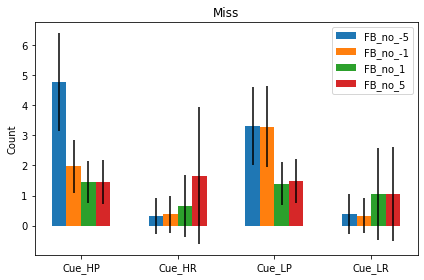

In [156]:
x_labels = means_miss.index.to_list()
y_labels = means_miss.columns.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()

i = 0
for col in means_miss:
    rects1 = ax.bar(x = x+i*width-width/2*3, 
                    height = means_miss[col].tolist(), yerr=std_miss[col].tolist(), 
                    width = width, label=y_labels[i])
    i+=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Miss')
ax.set_xticks(x, x_labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# this is for run1, do it for run2 as well; or see if it makes sense to concatenate them (probably does because now the max count is 5...not much)